In [1]:
import ic_sets, auction_data, os
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('white')
%matplotlib inline

In [4]:
pd.read_csv('tests/reference_data/tsuchiura_data.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb7 in position 36: invalid start byte

## auction analysis packages
- auction_data provides tools to access, compute statistics of interest, and manipulate procurement auction data
- ic_sets provides analytic tools to assess the share of data consistent with competition

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb7 in position 36: invalid start byte

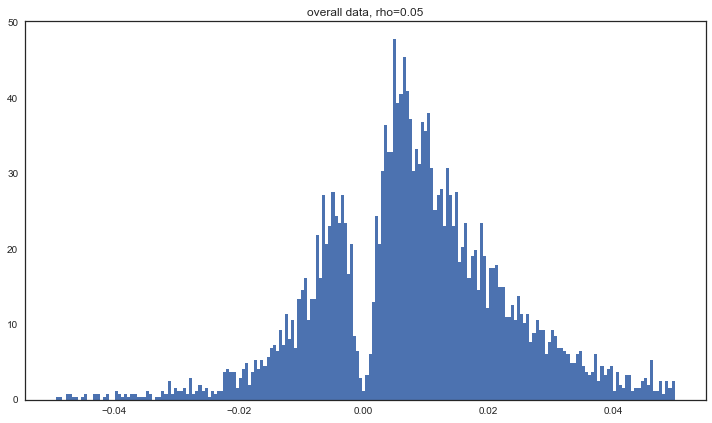

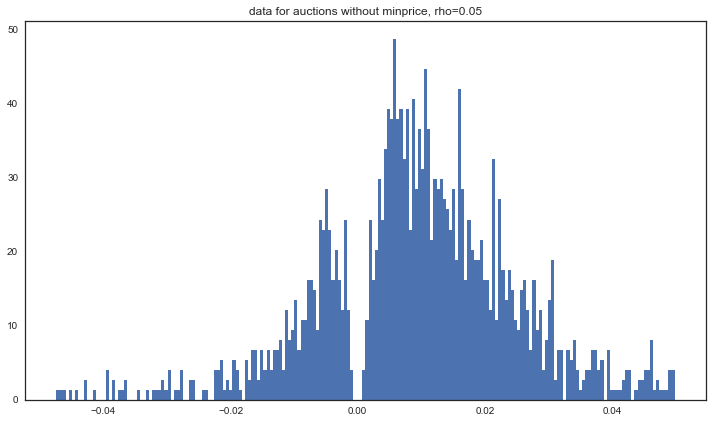

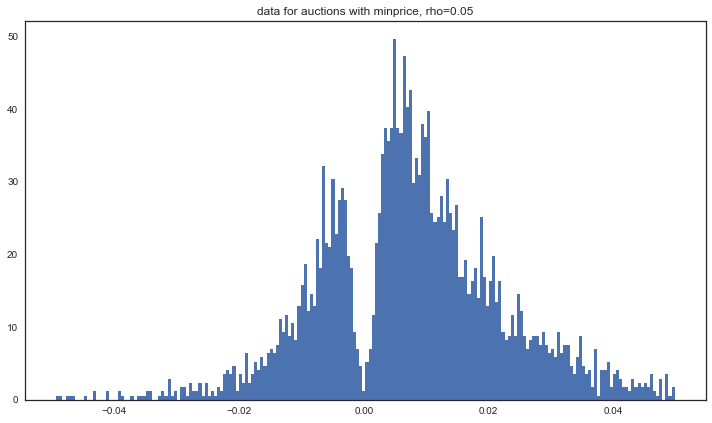

In [4]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta,'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

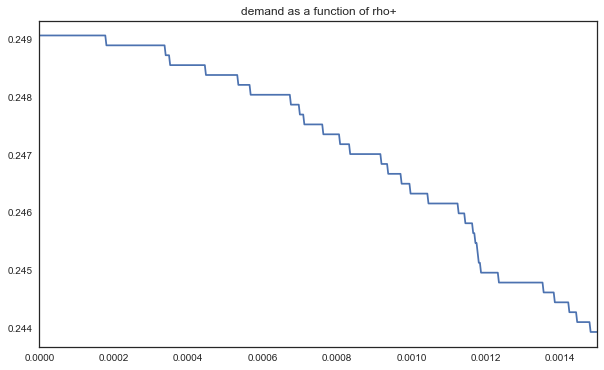

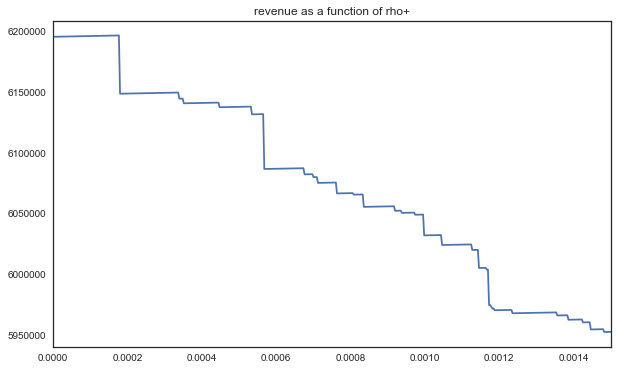

In [5]:
tsuchiura_data.get_counterfactual_demand(.0015,.0).demand.plot(figsize = (10,6))
plt.title('demand as a function of rho+')
plt.show()

tsuchiura_data.get_counterfactual_demand(.0015,.0).revenue.plot(figsize = (10,6))
plt.title('revenue as a function of rho+')
plt.show()

## Illustrating the use of ic_sets
here I illustrate the basic methods of ic_sets as well as plotting functionalities 

In [82]:
ic_solver = ic_sets.ICSets(rho_p=.001, rho_m=.001, auction_data=tsuchiura_data, k=.1, t=.0, m=m)

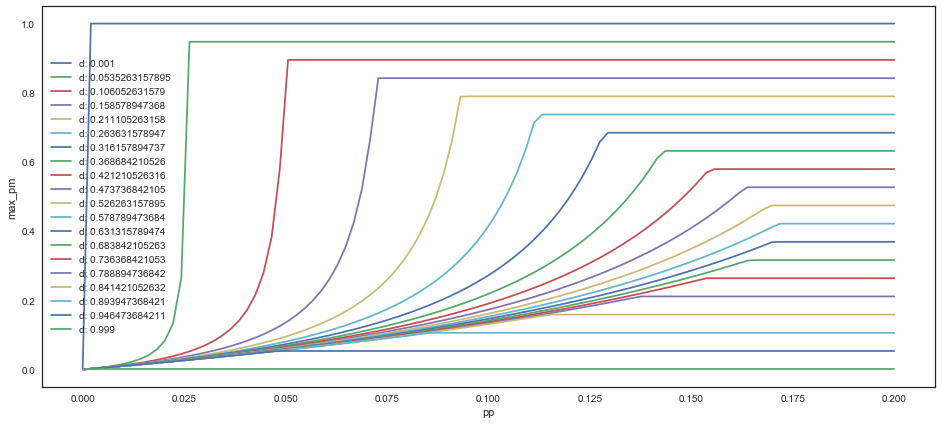

In [83]:
# illustrating value_pm where it is constrained by IC 
legend = []
plt.figure(figsize=(16,7))
for d in np.linspace(0.001, .999, 20):
    range_pp = np.linspace(ic_solver.lower_slope_pp * d, .2, 100)
    max_pm = [ic_solver.value_pm(d, pp) for pp in range_pp]
    plt.plot(range_pp, max_pm)
    legend.append('d: {}'.format(d))
plt.legend(legend)
plt.xlabel('pp')
plt.ylabel('max_pm')

plt.show()

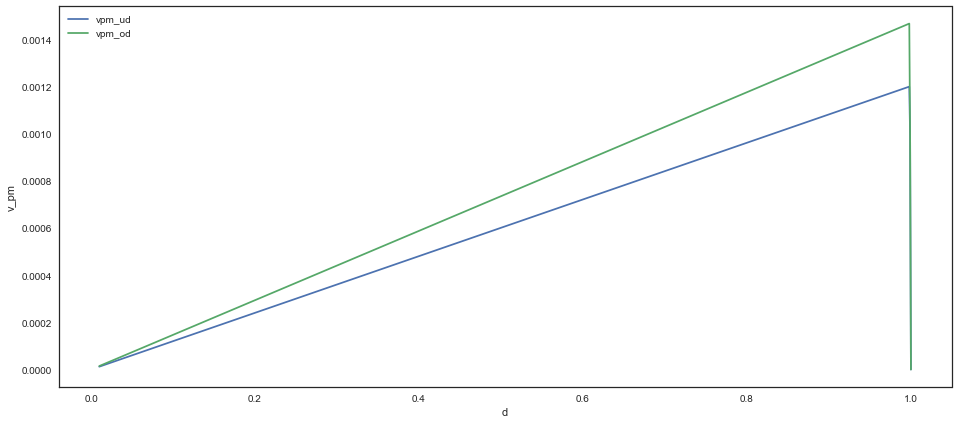

In [84]:
# illustrating that the lowest value of value_pm is attained at u_d

legend = ['vpm_ud', 'vpm_od']
plt.figure(figsize=(16,7))
u_d_val = []
o_d_val = []
d_range = np.linspace(0.01, 1., 1000) 
for d in d_range:
    u_d, o_d = .9 * d, 1.1 * d
    vpm_ud, vpm_od = (ic_solver.value_pm(d, ic_solver.lower_slope_pp * d_) for d_ in [u_d, o_d])
    u_d_val.append(vpm_ud)
    o_d_val.append(vpm_od)
plt.plot(d_range, u_d_val)
plt.plot(d_range, o_d_val)
plt.legend(legend)
plt.xlabel('d')
plt.ylabel('v_pm')

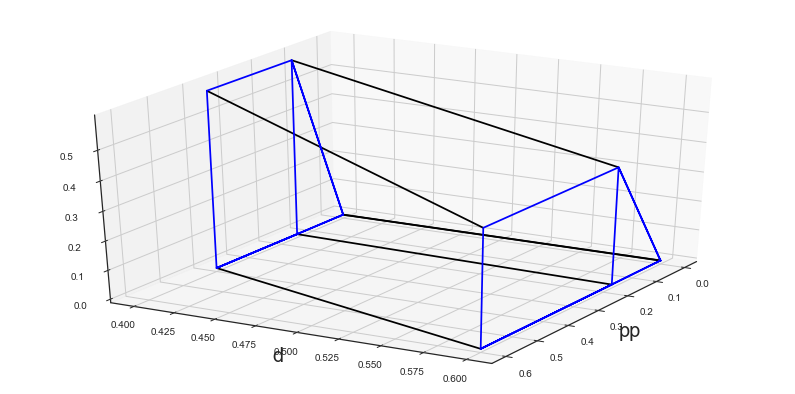

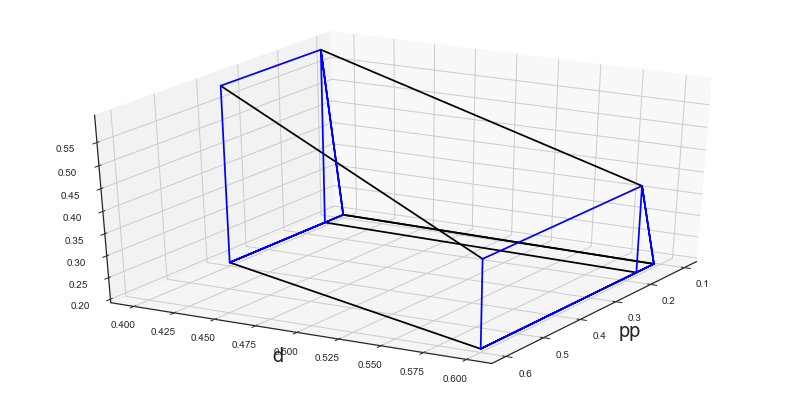

In [85]:
# plotting set_z for different values of u_pm tools

ic_solver.plot_z(.4, .6, .0)
ic_solver.plot_z(.4, .6, .2)
plt.show()

True


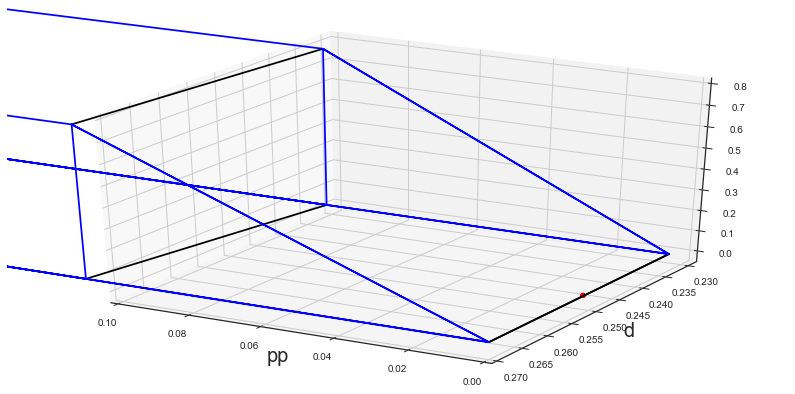

In [87]:
# assessing and plotting relevant set for some assignment of competitive auctions
ic_solver = ic_sets.ICSets(rho_p=.001, rho_m=.001, auction_data=tsuchiura_data, k=.1, t=.0, m=m)

p_c = (1, 1, 1, 1)
print ic_solver.is_rationalizable(p_c, 'plot')
plt.xlim(0, .1)
plt.show()

False


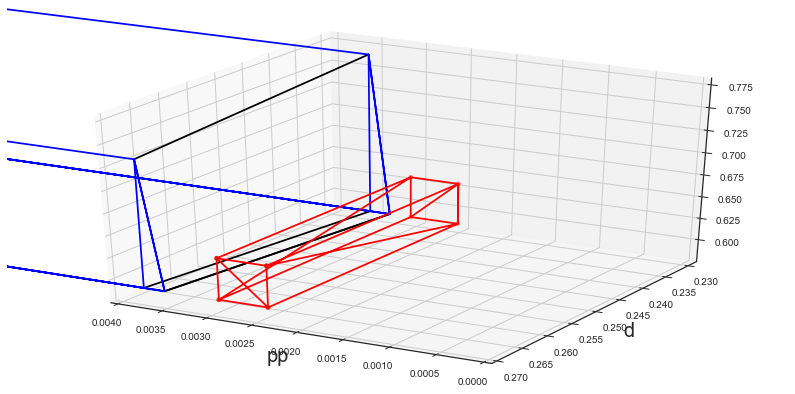

In [88]:
ic_solver.set_tolerance_parameters(k=.1, t=.05, m=.5) 
ic_solver.set_deviations(rho_p=.001, rho_m=.05)

print ic_solver.is_rationalizable(p_c, 'plot')
plt.xlim(0, .004)
plt.show()

## Example: inference from upper and lower deviations as $m$ varies -- i.i.d. case

In [89]:
data = []
index = []
list_m = [.01, .05, .1, .5, 1, 2, 3]
for m in list_m:
    ic_solver = ic_sets.ICSets(rho_p=.001, rho_m=.02, auction_data=tsuchiura_data, k=0, t=.0, m=m)
    data.append(ic_solver.assess_share_competitive_iid(6))

df = pd.DataFrame(data, index=list_m)
df.index.name = 'm'
df

,arg_max,non_comp_IC,non_comp_tied_bids
m,,,
0.01,"(1.0, 0.0, 1.0, 1.0)",0.245235,0.004425
0.05,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425
0.10,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425
0.50,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425
1.00,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425
2.00,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425
3.00,"(1.0, 0.2, 1.0, 1.0)",0.196188,0.004425


I'm slightly concerned that $m$ only matters when it's very high.
It's worth double checking that there is no mistake.

To Do: expand tests

## Example: inference from upper deviation alone as $m$ varies

This should be equivalent to the case where there are no information constraints

- this requires an implementation of Juan's direct tight bound
- build a test to ensure that the special results match those of the general case 
  (maybe along the lines of test_rationalizable_iid)